In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Author: Milan Ondrasovic <milan.ondrasovic@gmail.com>
#
# MIT License
#
# Copyright (c) 2021 Milan Ondrašovič
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors

from IPython.display import display

%load_ext autoreload
%autoreload 2

In [6]:
def image_show(img):
    win_name = 'preview'
    cv.imshow(win_name, img)
    cv.waitKey(0)
    cv.destroyWindow(win_name)

def draw_vertices(img, vertices, color, thickness=3):
    cv.polylines(
        img, vertices.round().astype(np.int), True, color, thickness,
        cv.LINE_AA
    )

def draw_points_groups_labels(img, points_groups, color, thickness=3):
    centroids = np.mean(points_groups, axis=1).round().astype(np.int)
    for i, centroid in enumerate(centroids, 1):
        cv.putText(
            img, str(i), tuple(centroid), cv.FONT_HERSHEY_SIMPLEX, fontScale=1,
            color=color, thickness=thickness
        )

def np_load(dir_path, file_name):
    return np.load(str(dir_path / f'{file_name}.npy'))

In [10]:
class ImageIllustrator:
    def __init__(self, shape, color='white'):
        image = np.ones((*shape, 3)) * np.asarray(colors.to_rgb(color))
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(image)
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.set_axis_off()

    def draw_boxes(self, boxes, line_width=3, color='black', alpha=1):
        draw_params = dict(
            closed=True, linewidth=line_width, antialiased=True, color=color,
            alpha=alpha
        )
        for box in boxes:
            polygon = patches.Polygon(box, **draw_params)
            self.ax.add_patch(polygon)

    def save(self, file_path, dpi=300):
        self.fig.savefig(file_path, dpi=dpi)

    def show(self):
        display(self.fig)

# illustr_orig = ImageIllustrator(img_shape_orig, 'silver')
# illustr_orig.draw_boxes(points_groups_orig, color='midnightblue')
# illustr_orig.save("../markers_orig.pdf")
#
# shift = np.array([10, 10])
# illustr_warped = ImageIllustrator(tuple(shift * 2 + img_shape_warped))
# illustr_warped.draw_boxes(img_corners_warped[None, ...] + shift, color='silver')
# illustr_warped.draw_boxes(points_groups_warped + shift, color='midnightblue')
# illustr_warped.save("../markers_warped.pdf")

In [ ]:
# group_index = 0
# homography, _ = cv.findHomography(
#     points_groups_warped[group_index], points_groups_orig[group_index])
# img_rectified = cv.warpPerspective(
#     img_warped, homography, (img_shape[1], img_shape[0]))
# image_show(img_rectified)

[[   9.99999935   10.00000005]
 [ 954.16558838   22.98691177]
 [1055.09765625  732.4229126 ]
 [  79.21074677  768.68487549]]
[[146.97992686 201.67113192]
 [149.57991761  77.64310764]
 [278.09966415  95.07600055]
 [275.48680186 216.2625254 ]]
[[505.05357025 262.69681452]
 [416.94070576 165.37118116]
 [500.31884323  85.22601314]
 [588.45931778 183.53849017]]
[[871.45916927 249.29121061]
 [746.86577147 225.03860345]
 [753.13638655  97.78296215]
 [881.58694584 126.72055908]]
[[193.63663761 419.69060542]
 [211.15554933 323.45144294]
 [311.37556072 350.59888687]
 [290.66452993 447.52437991]]
[[576.9420588  433.03029742]
 [493.44529986 402.91024294]
 [512.6788831  322.02194772]
 [595.58391624 352.30352118]]
[[788.03831127 440.56740144]
 [765.75841838 314.76271213]
 [886.62266547 306.97728643]
 [911.40311809 430.57410642]]
[[169.54521604 607.89234636]
 [238.70122802 495.64794657]
 [357.5152257  572.30519194]
 [288.96445495 689.12171806]]
[[578.73356643 646.81614801]
 [503.95464567 597.90516374

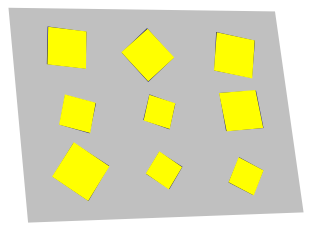

In [44]:
import config

from datagen.shape import RectangleGenerator
from datagen.layout import ShapesLayoutGenerator, build_grid_layout
from experiment_runner import (
    rand_rotate_angles, rand_translation_coefs, rand_noise_coefs,
    rand_scale_coef
)
from datagen.transform import Rotation, Translation, Scale, Pipeline
from datagen.rotation import Rotation3DGenerator

n_rows = n_cols = 3

position_gens = build_grid_layout(n_rows, n_cols)
shape_gen = RectangleGenerator(config.SHAPE_BOX_WIDTH, config.SHAPE_BOX_WIDTH)
layout_gen = ShapesLayoutGenerator(
    config.IMG_WIDTH, config.IMG_HEIGHT, shape_gen, position_gens
)

rand_rotate = Rotation(rand_rotate_angles, use_centroid=True)
rand_translate = Translation(rand_translation_coefs)
# Using non-uniform scale.
rand_scale = Scale(rand_scale_coef, use_centroid=True)

def rand_noise_coefs_int(points):
    return rand_noise_coefs(points).round()

rand_noise = Translation(rand_noise_coefs_int)

point_orig_transform = Pipeline(rand_translate, rand_rotate, rand_scale)

boxes = layout_gen.generate_points()
boxes = point_orig_transform.transform(boxes)

rotation_range = config.IMG_ROTATION_RANGE
rotation_gen = Rotation3DGenerator(
    rotation_range, rotation_range, rotation_range
)
rotation_transformer = rotation_gen.build_transformer()

boxes_warped = rotation_transformer.transform_points(
    boxes.reshape(-1, 2), (config.IMG_HEIGHT, config.IMG_WIDTH), True
).reshape(boxes.shape)

boxes_warped_noisy = rand_noise.transform(boxes_warped)

img_corners = np.float32((
    (0, 0),
    (config.IMG_WIDTH - 1, 0),
    (config.IMG_WIDTH - 1, config.IMG_HEIGHT - 1),
    (0, config.IMG_HEIGHT - 1),
))

img_corners_warped = rotation_transformer.transform_points(
    img_corners.reshape(-1, 2), (config.IMG_HEIGHT, config.IMG_WIDTH), True
).reshape(img_corners.shape)

min_x, min_y = np.min(img_corners_warped, axis=0)
max_x, max_y = np.max(img_corners_warped, axis=0)

img_shape_warped = np.array(
    (max_y - min_y, max_x - min_x)
).round().astype(np.int)

shift = np.array([10, 10])
illustrator = ImageIllustrator(tuple(shift * 2 + img_shape_warped))

illustrator.draw_boxes(img_corners_warped[None, ...] + shift, color='silver')
illustrator.draw_boxes(boxes_warped_noisy + shift, color='midnightblue')
illustrator.draw_boxes(boxes_warped + shift, color='yellow')
illustrator.save("../markers_warped.pdf")